# Huiswerkopgave - Old or Not

### Notebook by `Esmee Kraan, s1173469`

#### Gemaakt met behulp van chatGPT
---

## Table of contents

1. [Introduction](#Introduction)

2. [The problem domain](#The-problem-domain)

3. [Business Understanding](#Business-Understanding)

4. [Required libraries](#Required-libraries)

5. [Data Understanding](#Data-Understanding)

6. [Data Prepartion](#Data-Preparation)

7. [Modeling](#Modeling)

8. [Evaluation](#Evaluation)

9. [Reproducibility](#Reproducibility)

10. [Reference](#Reference)
---

# Introduction

[[ go back to the top ]](#Table-of-contents)

In deze notebook gaan we een neuraal netwerk bouwen dat kan bepalen of een beroemdheid jonger of ouder is dan 42 jaar. Het doel is om een model te trainen dat gezichten kan classificeren als 'not old' (tussen 21 en 42 jaar) of 'old' (ouder dan 42 jaar). We maken gebruik van de IMDB Faces Dataset, die meer dan 460.000 afbeeldingen bevat van beroemdheden met informatie over leeftijd en geslacht.

---

# The problem domain

[[ go back to the top ]](#Table-of-contents)

Dit project draait om leeftijdsclassificatie met behulp van gezichtsafbeeldingen van beroemdheden. Het bepalen van de leeftijd van volwassen beroemdheden op basis van hun uiterlijk kan lastig zijn voor mensen. We willen onderzoeken of een neuraal netwerk beter in staat is om te bepalen of iemand ouder is dan 42 jaar. 

We maken gebruik van de IMDB-WIKI dataset, één van de grootste publieke datasets met gezichtsafbeeldingen en leeftijdsinformatie. Deze dataset bevat gezichten van beroemdheden afkomstig van IMDB, inclusief metadata zoals leeftijd en geslacht. Voor dit project gebruiken we alleen de gegevens van volwassenen (21 jaar of ouder) en filteren we foto's waar meerdere gezichten of geen gezicht op staan.

De uitdaging in dit domein ligt niet alleen in de nauwkeurige classificatie van leeftijd, maar ook in het correct verwerken en filteren van de dataset. Door gebruik te maken van slechts 50.000 voorbeelden, willen we een model bouwen dat niet alleen goed presteert op de trainingsdata, maar ook goed generaliseert naar nieuwe, ongeziene afbeeldingen.

---

## Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset (https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.

Vul je antwoorden steeds op de juiste plaats in. Maak indien nodig extra cellen aan.

# Required Libraries - WIP

[[ go back to the top ]](#Table-of-contents)

Voor dit project maken we gebruik van verschillende Python-pakketten die nodig zijn om de data te analyseren, te modelleren en te visualiseren. Als je deze nog niet hebt geïnstalleerd, kun je ze gemakkelijk installeren via `conda` of `pip`.

De primaire bibliotheken die we gebruiken zijn:

* **pandas**: Een krachtige bibliotheek voor het opslaan en manipuleren van data in DataFrames.
* **NumPy**: Biedt ondersteuning voor numerieke arrays en wiskundige operaties.
* **tensorflow**: Deze bibliotheek gebruiken we voor het bouwen van neurale netwerken en het trainen van ons classificatiemodel.
* **matplotlib**: Basisplottingbibliotheek voor het visualiseren van data.
* **IPython.display (Markdown)**: Hiermee kunnen we dynamische Markdown-inhoud in Jupyter Notebooks weergeven.

Om ervoor te zorgen dat alle benodigde bibliotheken zijn geïnstalleerd, kun je de volgende commando's gebruiken:

```bash
conda install pandas numpy pytz matplotlib
pip install pandas numpy pytz matplotlib
```

In [113]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import cv2
import os
from sklearn.model_selection import train_test_split
import datetime as date
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from sklearn.metrics import confusion_matrix

# Data Understanding

[[ go back to the top ]](#Table-of-contents)

Voor zowel de IMDb- als Wikipedia-afbeeldingen wordt een apart `.mat`-bestand geleverd, dat kan worden geladen met Matlab en alle metadata bevat. Hieronder volgt een toelichting van de belangrijkste variabelen:

- **dob**: Dit staat voor de geboortedatum van de beroemdheid, opgeslagen als een Matlab-serieel datumgetal.
- **photo_taken**: Het jaar waarin de foto is genomen.
- **full_path**: Het pad naar de afbeeldingsbestanden.
- **gender**: Het geslacht van de beroemdheid, waarbij 0 voor vrouw en 1 voor man staat. Als het geslacht onbekend is, wordt deze waarde als `NaN` weergegeven.
- **name**: De naam van de beroemdheid.
- **face_location**: De locatie van het gezicht in de afbeelding. 
- **face_score:** Een score die aangeeft hoe goed de gezichtsdetector het gezicht heeft gedetecteerd; hoe hoger, hoe beter. Als de score Inf is, betekent dit dat er geen gezicht in de afbeelding is gevonden en geeft de face_location de gehele afbeelding terug.
- **second_face_score:** De score van een tweede gedetecteerd gezicht (indien aanwezig). Dit is nuttig om afbeeldingen met meerdere gezichten te negeren. Als er geen tweede gezicht is gevonden, is deze waarde NaN.
- **celeb_names (alleen IMDB):** Een lijst met de namen van alle beroemdheden in de dataset.
- **celeb_id (alleen IMDB):** Een index die verwijst naar de naam van een beroemdheid in de lijst met namen.

In Matlab kun je het gezicht bijsnijden door de volgende code te gebruiken:
  
```bash
img(face_location(2):face_location(4), face_location(1):face_location(3), :)
```

bron: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ onder het kopje <u> Usage </u>

In [80]:
#Lees de metadata in, bestudeer deze en maak voor iedere relevante variabele een aparte list aan
# Laad het .mat bestand met metadata
mat = scipy.io.loadmat('../../bijlagen/imdb_crop/imdb.mat')
print(mat.keys())  # Bekijk de sleutels in het bestand

dict_keys(['__header__', '__version__', '__globals__', 'imdb'])


Ik heb wat onderzoek gedaan wat deze keys betekenen en kwam op de volgende uitkomsten:
* __header__, __version__, __globals__: Deze komen vaak voor in .mat-bestanden en bevatten metadata over het bestand zelf (zoals versies en headers), wat meestal niet direct relevant is voor de analyse.
* `imdb:` Dit is de belangrijkste sleutel. Het bevat de daadwerkelijke dataset waar we mee gaan werken. We gebruiken deze variabele om toegang te krijgen tot de gegevens.

In [81]:
# Verkrijg en verken de 'imdb' data
imdb_data = mat['imdb']
print(imdb_data.dtype)  # Bekijk de structuur van de 'imdb' data

[('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]


Hier kijkt ik nogmaals welke soort data er in zit, maar ik wist niet waar 'O' voor stond. Dus heb ik dat opgezocht:
* (`O`, wat voor object staat, vaak arrays of lijsten).
De betekenis achter elke variabele staat in de [Data Understanding](#Data-Understanding)

In [82]:
# Verkrijg gegevens en zet deze om
imdb_dob = imdb_data[0][0][0][0]
imdb_photo_taken = imdb_data[0][0][1][0]
imdb_full_path = imdb_data[0][0][2][0]
imdb_gender = imdb_data[0][0][3][0]
imdb_face_score1 = imdb_data[0][0][6][0]
imdb_face_score2 = imdb_data[0][0][7][0]

# Bekijk de eerste paar waarden
print(imdb_dob[:5])
print(imdb_photo_taken[:5])
print(imdb_full_path[:5])
print(imdb_gender[:5])
print(imdb_face_score1[:5])
print(imdb_face_score2[:5])

[693726 693726 693726 693726 693726]
[1968 1970 1968 1968 1968]
[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43')
 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44')
 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43')
 array(['01/nm0000001_rm946909184_1899-5-10_1968.jpg'], dtype='<U43')
 array(['01/nm0000001_rm980463616_1899-5-10_1968.jpg'], dtype='<U43')]
[1. 1. 1. 1. 1.]
[1.45969291 2.5431976  3.45557949 1.87211717 1.15876579]
[1.11897336 1.85200773 2.98566022        nan        nan]


In [83]:
# Inspecteer de vorm van enkele arrays
print("Shape of face_score:", imdb_face_score1.shape)
print("Shape of second_face_score:", imdb_face_score2.shape)
print("Shape of dob:", imdb_dob.shape)
print("Shape of photo_taken:", imdb_photo_taken.shape)
print("Shape of full_path:", imdb_full_path.shape)
print("Shape of gender:", imdb_gender.shape)

Shape of face_score: (460723,)
Shape of second_face_score: (460723,)
Shape of dob: (460723,)
Shape of photo_taken: (460723,)
Shape of full_path: (460723,)
Shape of gender: (460723,)


Wat me gelijk opvalt is hoe de geboortedatums zijn opgeslagen, op de website stond vermeld dat dit als 'Matlab-serieel datumgetal' is.

## Data preparation: 
Omdat we de leeftijd van de personen moeten omrekenen converteer ik de geboortedatums die zijn opgeslagen in Matlab's serial date nummer formaat naar Python's `datetime` objecten om ze leesbaar en bruikbaar te maken. Matlab serial date nummers zijn niet direct bruikbaar in Python. `matlab_datenum_to_date` zorgt ervoor dat we de datums omzetten naar een formaat dat we kunnen manipuleren en gebruiken in verdere analyses.


Daarna bereken ik de leeftijd van een persoon op basis van hun geboortedatum en het jaar waarin de foto is genomen met de functie `calculate_age`. Door de leeftijd te berekenen, kunnen we inzichten verkrijgen over de leeftijdsdistributie van de personen in de dataset.

Ook verwijder ik ongeldige leeftijdswaarden die ontstaan door foutieve of ontbrekende datums. Omdat negatieve leeftijden duiden op fouten in de gegevensverwerking. Het verwijderen van deze waarden zorgt ervoor dat de uiteindelijke dataset schoon en bruikbaar is voor verdere analyse en visualisatie.

In [84]:
# Omzetten van dob (geboortedatums) naar datetime objecten
def matlab_datenum_to_date(matlab_datenum):
    try:
        if matlab_datenum > 0:
            return date.datetime.fromordinal(int(matlab_datenum)) + date.timedelta(days=int(matlab_datenum) % 1) - date.timedelta(days=366)
        else:
            return None
    except OverflowError:
        return None

# Functie om de leeftijd te berekenen
def calculate_age(dob, photo_year):
    try:
        if dob is None or isinstance(dob, date.datetime) is False:
            return -1

        return photo_year - dob.year
    except Exception as e:
        print(f"Fout bij het berekenen van de leeftijd: {e}")
        return -1

# Converteer de geboortedatums naar datetime objecten
dob_converted = np.array([matlab_datenum_to_date(d) if not np.isnan(d) else None for d in imdb_dob.flatten()])

# Haal het jaar van de foto op
photo_year = imdb_photo_taken.flatten()

# Bereken de leeftijden, waarbij ongeldige datums en onbekende leeftijden worden afgehandeld
ages = np.array([calculate_age(d, y) for d, y in zip(dob_converted, photo_year)])

# Verwijder negatieve leeftijden (indien nodig)
ages = ages[ages != -1]

# print("Voorbeelden van ages:", ages[:10]) # Debug informatie: kijk naar enkele waarden van ages
# print(f"Grootte van de ages array: {ages.size}") # Debug: controleer de grootte van de ages array

#### Leeftijden filteren.
Ik verwijder alle leeftijden onder de 21 jaar omdat de opdracht was om ons te beperken tot volwassen beroemdheden. Ook filter ik onrealistische leeftijden eruit, uit onderzoek blijkt dat [Jeanne Calment](https://nl.wikipedia.org/wiki/Jeanne_Calment) uit Frankrijk het oudste persoon ooit is met 122 jaar. Daarom neem ik dat als mijn hoogste leeftijd.

In [85]:
# Filter de leeftijden om alleen waarden van 21 jaar en ouder te behouden
filtered_ages = ages[ages >= 21]

# Verwijder onrealistische leeftijden (bijv. boven 122 jaar)
filtered_ages = filtered_ages [filtered_ages  <= 122]

Minimale leeftijd: 21
Maximale leeftijd: 119
Gemiddelde leeftijd: 38.688233826395624
Standaardafwijking: 12.068945851105074


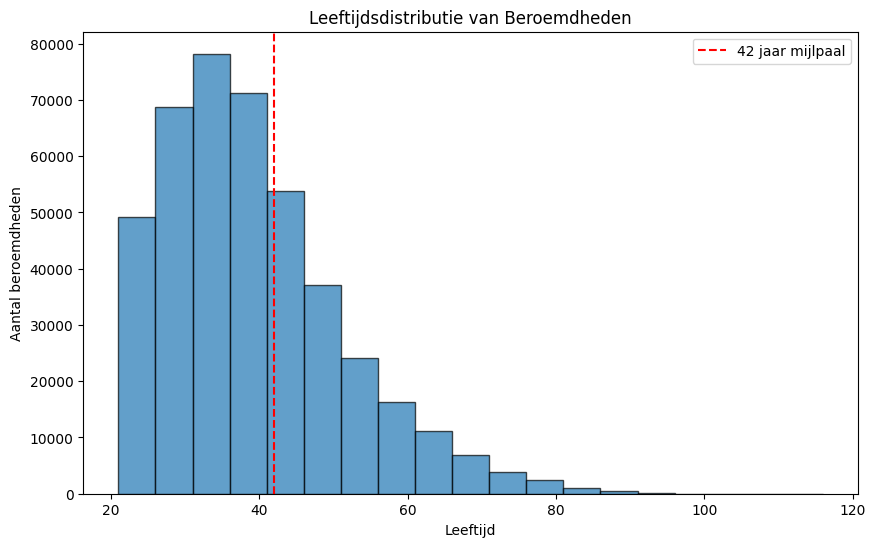

In [86]:
# Controleer de statistieken van de gefilterde leeftijden
print(f"Minimale leeftijd: {filtered_ages.min()}")
print(f"Maximale leeftijd: {filtered_ages.max()}")
print(f"Gemiddelde leeftijd: {filtered_ages.mean()}")
print(f"Standaardafwijking: {filtered_ages.std()}")

# Plot de histogram van de leeftijden
plt.figure(figsize=(10, 6))
plt.hist(filtered_ages, bins=range(21, 121, 5), edgecolor='black', alpha=0.7)

# Voeg een verticale lijn toe op 42
plt.axvline(x=42, color='red', linestyle='--', label='42 jaar mijlpaal')

# Voeg labels en titel toe
plt.xlabel('Leeftijd')
plt.ylabel('Aantal beroemdheden')
plt.title('Leeftijdsdistributie van Beroemdheden')
plt.legend()

# Toon de plot
plt.show()

Percentage onder 42 jaar: 65.70%
Percentage 42 jaar en ouder: 34.30%


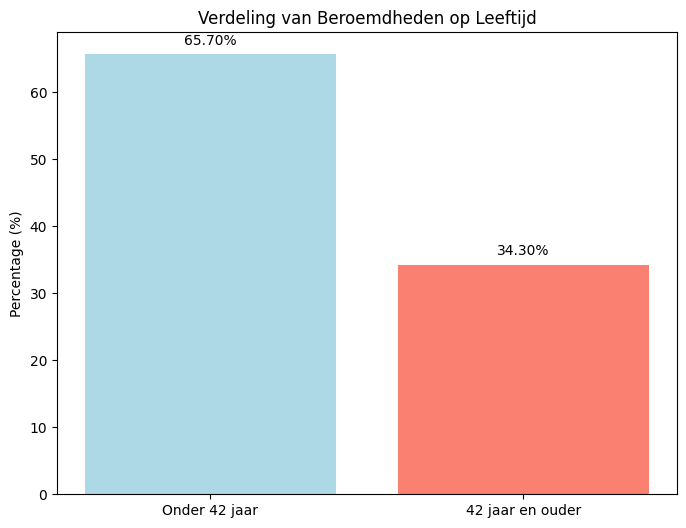

In [87]:
# Bereken percentages onder en boven 42 jaar
below_42 = np.sum(filtered_ages < 42)
above_42 = np.sum(filtered_ages >= 42)

total_count = len(filtered_ages)

percentage_below_42 = (below_42 / total_count) * 100
percentage_above_42 = (above_42 / total_count) * 100

# Print de percentages
print(f"Percentage onder 42 jaar: {percentage_below_42:.2f}%")
print(f"Percentage 42 jaar en ouder: {percentage_above_42:.2f}%")

# Visualiseer de verdeling met een staafdiagram
plt.figure(figsize=(8, 6))
categories = ['Onder 42 jaar', '42 jaar en ouder']
percentages = [percentage_below_42, percentage_above_42]

plt.bar(categories, percentages, color=['lightblue', 'salmon'])
plt.ylabel('Percentage (%)')
plt.title('Verdeling van Beroemdheden op Leeftijd')

# Voeg de percentages toe boven de staven
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom') # type: ignore

plt.show()

Op basis van de dataset heb ik de volgende bevindingen:

- **Minimale leeftijd:** 21 jaar
- **Maximale leeftijd:** 119 jaar
- **Gemiddelde leeftijd:** Ongeveer 38.7 jaar
- **Standaardafwijking:** Ongeveer 12.1 jaar

Van de beroemdheden in de dataset:

- 65.70% is jonger dan 42 jaar.
- 34.30% is 42 jaar of ouder.

Deze verdeling geeft een goed overzicht van de leeftijdsopbouw van de beroemdheden in onze dataset, met een meerderheid die jonger is dan 42 jaar.

## Data Preprocessing

In [88]:
# Inspecteer de structuur van de imdb_data
for key in imdb_data.dtype.names:
    print(f"Key: {key}, Shape: {imdb_data[key].shape}, Type: {type(imdb_data[key])}")

Key: dob, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: photo_taken, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: full_path, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: gender, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: name, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: face_location, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: face_score, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: second_face_score, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: celeb_names, Shape: (1, 1), Type: <class 'numpy.ndarray'>
Key: celeb_id, Shape: (1, 1), Type: <class 'numpy.ndarray'>


In [89]:
# Verwerk paden en geslachten
imdb_path = ['imdb_crop/' + path[0] for path in imdb_full_path]
imdb_genders = ['male' if gender == 1 else 'female' for gender in imdb_gender]

In [90]:
# Verwerk geboortedatums
imdb_dob = []
for file in imdb_path:
    temp = file.split('_')[3]
    temp = temp.split('-')
    temp[1] = temp[1].zfill(2)  # Voeg een voorloopnul toe
    temp[2] = temp[2].zfill(2)  # Voeg een voorloopnul toe

    # Zorg ervoor dat de maand en dag niet op '00' staan
    temp[1] = '01' if temp[1] == '00' else temp[1]
    temp[2] = '01' if temp[2] == '00' else temp[2]

    imdb_dob.append('-'.join(temp))

In [91]:
# Bereken leeftijden
imdb_age = []
for i in range(len(imdb_dob)):
    try:
        d1 = date.datetime.strptime(imdb_dob[i][0:10], '%Y-%m-%d')
        d2 = date.datetime.strptime(str(imdb_photo_taken[i]), '%Y')
        rdelta = relativedelta(d2, d1)
        diff = rdelta.years
    except Exception as ex:
        print(ex)
        diff = -1
    imdb_age.append(diff)

time data '0-12-22' does not match format '%Y-%m-%d'
time data '0-05-21' does not match format '%Y-%m-%d'
time data '0-11-18' does not match format '%Y-%m-%d'
time data '0-11-18' does not match format '%Y-%m-%d'
time data '0-11-18' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-%m-%d'
time data '0-07-31' does not match format '%Y-

In [92]:
# Maak een DataFrame met de verwerkte gegevens
final_imdb = np.vstack((imdb_age, imdb_genders, imdb_path, imdb_face_score1, imdb_face_score2)).T
final_imdb_df = pd.DataFrame(final_imdb, columns=['age', 'gender', 'path', 'face_score1', 'face_score2'])

In [93]:
# Opschonen van de DataFrame
meta = final_imdb_df
meta = meta[meta['face_score1'] != '-inf']
meta = meta[meta['face_score2'] == 'nan']
meta = meta.drop(['face_score1', 'face_score2'], axis=1)
meta = meta.sample(frac=1).reset_index(drop=True)

# Opslaan in een CSV bestand
#meta.to_csv('meta.csv', index=False)

In [94]:
# Lees de opgeslagen metadata CSV in
meta = pd.read_csv('../../bijlagen/imdb_crop/meta.csv')

In [95]:
# Selecteer gegevens op basis van leeftijd
old = meta[meta["age"].between(43, 101)].iloc[:25000]
not_old = meta[meta["age"].between(21, 42)].iloc[:25000]
meta = pd.concat([old, not_old])

# Verwijder de geslachtskolom en voeg 'old_or_not' kolom toe
meta = meta.drop(['gender'], axis=1)
meta['old_or_not'] = (meta['age'] > 42).astype(int)

Ik filter hier de dataset op basis van leeftijd en hoeveel gedecterde gezichten er zijn op de foto.

- **Minimale Leeftijd**: Beperk de dataset tot personen die 21 jaar of ouder zijn.
- **Maximale Leeftijd**: Beperk de dataset tot personen die 122 jaar of jonger zijn.

- **Geen Gezicht Gedetecteerd**: Verwijder afbeeldingen waar de `face_score` gelijk is aan `Inf`, wat aangeeft dat er geen gezicht is gedetecteerd.
- **Meerdere Gezichten**: Verwijder afbeeldingen waar de `second_face_score` een waarde heeft (d.w.z., niet NaN), wat betekent dat er meerdere gezichten zijn gedetecteerd.

De gefilterde DataFrame bevat nu alleen afbeeldingen met realistische leeftijden en met één goed gedetecteerd gezicht.

Omdat ik nu veel filters heb toegevoegd en andere dingen heb gedaan aan de dataset is de index een beetje in de war. Soms springt hij van 1 naar 4 naar 7 naar 10. Daarom ga ik de index even resetten.

In [96]:
# Index resetten want veel data is weggevallen door het opschonen
meta = meta.reset_index()
meta = meta.drop(['index'], axis=1)

In [97]:
# Controleer de eerste paar rijen
print(meta.head())

   age                                               path  old_or_not
0   44  imdb_crop/49/nm0000949_rm3860330752_1969-5-14_...           1
1   47  imdb_crop/48/nm0001448_rm4197486080_1949-4-20_...           1
2   46  imdb_crop/20/nm0925220_rm3367813120_1967-11-10...           1
3   43  imdb_crop/89/nm0293889_rm1010079744_1960-11-27...           1
4   44  imdb_crop/69/nm0000369_rm1017089536_1964-2-18_...           1


In [98]:
print(final_imdb_df.shape)
print(meta.shape)

(460723, 5)
(50000, 3)


Na het filteren en de dataset verminderen tot 25000 jonge mensen en 25000 oude mensen is de dataframe van 460723 naar 50000 gegaan.

In [99]:
# Splits de gefilterde dataset in train- en testset
# 20% van de data wordt gebruikt als testset
# random_state=42 zorgt voor reproduceerbare splits
df_train, df_test = train_test_split(meta, test_size=0.2, random_state=42)

# Converteer naar een array
df_train, df_test = df_train.values, df_test.values

# Print de vormen van de train- en testsets
print("Trainset vorm:", df_train.shape)
print("Testset vorm:", df_test.shape)

Trainset vorm: (40000, 3)
Testset vorm: (10000, 3)


### Afbeeldingsverwerking

Ik liep veel tegen dit punt aan, de afbeeldingen verwerken en opslaan voor de train- en test dataset. Daarom heb ik tijdens de les hulp gevraagd van Raymond, zo hebben we samen mijn code herschreven met behulp van deze openbare [GitHub](https://github.com/imdeepmind/processed-imdb-wiki-dataset).


In [100]:
# Maak de directorystructuur aan
for i in range(102):
    # Training directories
    os.makedirs(f'../../bijlagen/imdb_crop/train/{i}', exist_ok=True)
    # Testing directories
    os.makedirs(f'../../bijlagen/imdb_crop/test/{i}', exist_ok=True)

In [101]:
# Verwerk en sla de trainingsafbeeldingen op
counter_train = 0
for image in df_train:
    file_path = os.path.join('../../bijlagen/', image[1])  # Combineer basispad met relatieve pad
    age = int(image[0])  # De leeftijd

    try:
        img = cv2.imread(file_path, 1)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Zorgt ervoor dat alle foto's niet blauw zijn.
            img = cv2.resize(img, (64, 64))
            # Opslaan in de juiste map op basis van leeftijd
            output_path = os.path.join('../../bijlagen/imdb_crop/train/', str(age), f'{counter_train}_{str(image[2])}.jpg')
            cv2.imwrite(output_path, img)
            #print(f'--({counter_train}) Processing Training Image--')
            counter_train += 1
        else:
            print(f"Warning: Image at path {file_path} could not be read.")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Verwerk en sla de testafbeeldingen op
counter_test = 0
for image in df_test:
    file_path = os.path.join('../../bijlagen/', image[1])  # Combineer basispad met relatieve pad
    age = int(image[0])  # De leeftijd

    try:
        img = cv2.imread(file_path, 1)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Zorgt ervoor dat alle foto's niet blauw zijn.
            img = cv2.resize(img, (64, 64))
            # Opslaan in de juiste map op basis van leeftijd
            output_path = os.path.join('../../bijlagen/imdb_crop/test/', str(age), f'{counter_test}_{str(image[2])}.jpg')
            cv2.imwrite(output_path, img)
            #print(f'--({counter_test}) Processing Test Image--')
            counter_test += 1
        else:
            print(f"Warning: Image at path {file_path} could not be read.")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

Deze code voert de volgende taken uit:

### Kernpunten
- **Mappenstructuur**: Er worden mappen gemaakt voor elke leeftijd (0-101), zowel voor `train` als `test`.
- **Afbeeldingsverwerking**: Afbeeldingen worden gelezen en geschaald naar 64x64 pixels.
- **Bestandsopslag**: Afbeeldingen worden opgeslagen in leeftijdspecifieke mappen met unieke bestandsnamen.
- **Foutafhandeling**: Er is basisfoutafhandeling voor gevallen waar afbeeldingen niet gelezen kunnen worden.

Op dezelfde github stond ook code om de afbeeldingen en labels te laden, deze heb ik dan ook van dezelfde [GitHub](https://github.com/imdeepmind/processed-imdb-wiki-dataset). over genomen.

In [102]:
# Definieer de afbeeldingsgrootte
img_size = (64, 64)

# Functie om afbeeldingen en labels te laden uit een map
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            try:
                # Haal het label uit de bestandsnaam
                label = int(filename.split('_')[1].split('.')[0])
                # Lees en wijzig de grootte van de afbeelding
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Unable to read image {img_path}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    return np.array(images), np.array(labels)

# Paden naar de trainings- en testmappen
train_dir = '../../bijlagen/imdb_crop/train'
test_dir = '../../bijlagen/imdb_crop/test'

# Initialiseer lijsten voor train- en testdata
train_images = []
train_labels = []
test_images = []
test_labels = []

# Laad de trainingsafbeeldingen en labels
for age_group in range(102):
    age_group_dir = os.path.join(train_dir, str(age_group))
    if os.path.exists(age_group_dir):
        images, labels = load_images_from_folder(age_group_dir)
        if len(images) > 0:
            train_images.append(images)
            train_labels.append(labels)
    else:
        print(f"Warning: Directory {age_group_dir} does not exist.")

# Lijsten samenvoegen tot single arrays
if len(train_images) > 0:
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

# Laad de testafbeeldingen en labels
for age_group in range(102):
    age_group_dir = os.path.join(test_dir, str(age_group))
    if os.path.exists(age_group_dir):
        images, labels = load_images_from_folder(age_group_dir)
        if len(images) > 0:
            test_images.append(images)
            test_labels.append(labels)
    else:
        print(f"Warning: Directory {age_group_dir} does not exist.")

# Lijsten samenvoegen tot enkele arrays
if len(test_images) > 0:
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

# Vorm van de arrays controleren
print(f'Train images shape: {train_images.shape}') # type: ignore
print(f'Train labels shape: {train_labels.shape}') # type: ignore
print(f'Test images shape: {test_images.shape}') # type: ignore
print(f'Test labels shape: {test_labels.shape}') # type: ignore

Train images shape: (40000, 64, 64, 3)
Train labels shape: (40000,)
Test images shape: (10000, 64, 64, 3)
Test labels shape: (10000,)


### Kernpunten

Deze code voert de volgende taken uit:

- **Afbeeldingsgrootte**: Alle afbeeldingen worden geschaald naar 64x64 pixels.
- **Laden van afbeeldingen**: Afbeeldingen worden uit mappen geladen en gelabeld op basis van de bestandsnaam.
- **Dataopslag**: Zowel trainings- als testdata worden uiteindelijk opgeslagen als genormaliseerde arrays.

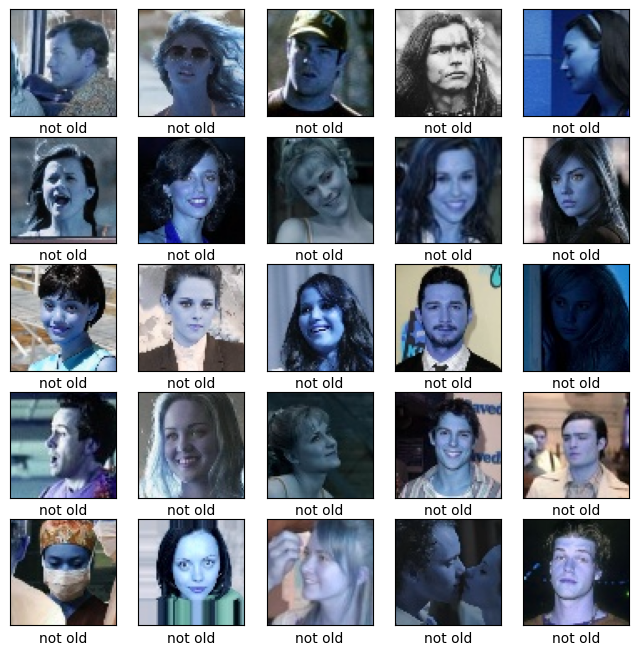

In [103]:
#toon de 1e 25 plaatjes met bijbehorende label (copy paste vorige les)
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(train_images[i])
    if train_labels[i]==1:
        plt.xlabel("old")
    else:
        plt.xlabel("not old")
plt.show()

## Modeling: 

### Model 1: Eenvoudig Convolutioneel Neuraal Netwerk

Model 1 is ontworpen als een eenvoudig convolutioneel neuraal netwerk (CNN) dat is geconfigureerd voor binaire classificatie. Het model bevat meerdere convolutionele lagen, die zijn ontworpen om belangrijke kenmerken uit de invoerafbeeldingen te extraheren. Het gebruik van L2-regularisatie helpt om overfitting te verminderen door de complexiteit van het model te beperken.

Belangrijkste Kenmerken:
- Convolutionele Lagen: Drie convolutionele lagen met een filtergrootte van 3x3, wat helpt bij het vastleggen van lokale kenmerken in de afbeeldingen.
- Max-Pooling: Gebruik van max-pooling om de dimensionaliteit van de feature maps te verkleinen, wat de rekentijd en de kans op overfitting vermindert.
- Batch Normalization: Dit verbetert de stabiliteit en versnelt het trainen van het netwerk door de activaties te normaliseren.
- Volledig Verbonden Lagen: Drie dense lagen voor classificatie met dropout om overfitting tegen te gaan.
- Outputlaag: Een enkele neuron met een sigmoid-activatiefunctie voor binaire classificatie.

In [104]:
# Normaliseren van de afbeeldingen naar waarden tussen 0 en 1
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

In [108]:
# Model definieren
model1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,385 (782.75 KB)

 Trainable params: 200,257 (782.25 KB)

 Non-trainable params: 128 (512.00 B)

In [109]:
# Compileren van het model met optimizer, loss en metrics
model1.compile(optimizer="ADAM",
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [110]:
# Model trainen voor 25 epochs
history1 = model1.fit(train_images, train_labels,
                    epochs=25,
                    batch_size=32,
                    validation_data=(test_images, test_labels))

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.5534 - loss: 0.6992 - val_accuracy: 0.6032 - val_loss: 0.6555
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6245 - loss: 0.6457 - val_accuracy: 0.5892 - val_loss: 0.6627
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6466 - loss: 0.6246 - val_accuracy: 0.5386 - val_loss: 0.7319
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6627 - loss: 0.6079 - val_accuracy: 0.5921 - val_loss: 0.6768
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.6784 - loss: 0.5930 - val_accuracy: 0.6778 - val_loss: 0.5953
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.6895 - loss: 0.5807 - val_accuracy: 0.6800 - val_loss: 0.5891
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7001 - loss: 0.5664 - val_accuracy: 0.6654 - val_loss: 0.6129
Epoch 8/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7105 -

## Evaluation: 

In [121]:
# Evaluatie van het model op de testset
test_loss, test_acc = model1.evaluate(test_images, test_labels, verbose=2)

# Print de test accuracy
print('\nTest accuracy:', test_acc)

313/313 - 3s - 10ms/step - accuracy: 0.6785 - loss: 0.7138

Test accuracy: 0.6784999966621399


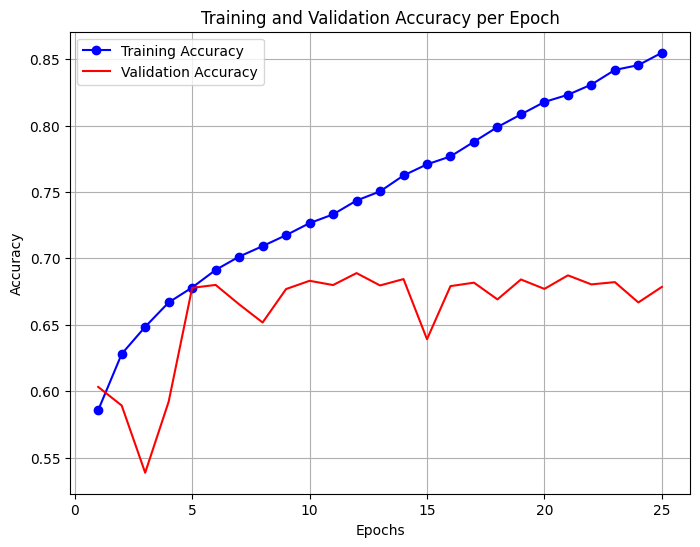

In [122]:
#plot de accuracy en validated accuracy (10 min)

# Extractie van de accuracies uit de history variabele
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

# Aantal epochs bepalen
epochs = range(1, len(acc) + 1)

# Plotten van de trainingsnauwkeurigheid en de validatienauwkeurigheid
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


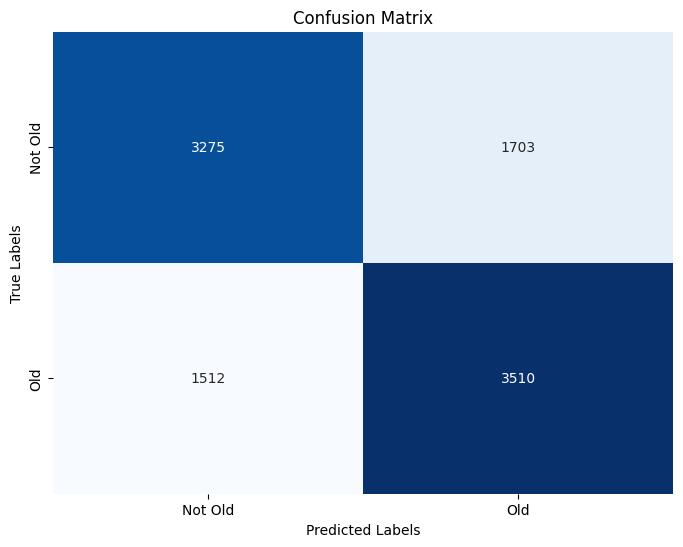

Confusion Matrix:
 [[3275 1703]
 [1512 3510]]


In [123]:
# Voorspellingen maken op de testset
test_predictions = model1.predict(test_images)
# Rond de voorspellingen af naar 0 of 1, omdat je een sigmoid-functie hebt (binary classification)
test_predictions = np.round(test_predictions)

# Confusion matrix maken
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Visualiseren van de confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Not Old", "Old"], yticklabels=["Not Old", "Old"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print de confusion matrix resultaten
print("Confusion Matrix:\n", conf_matrix)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


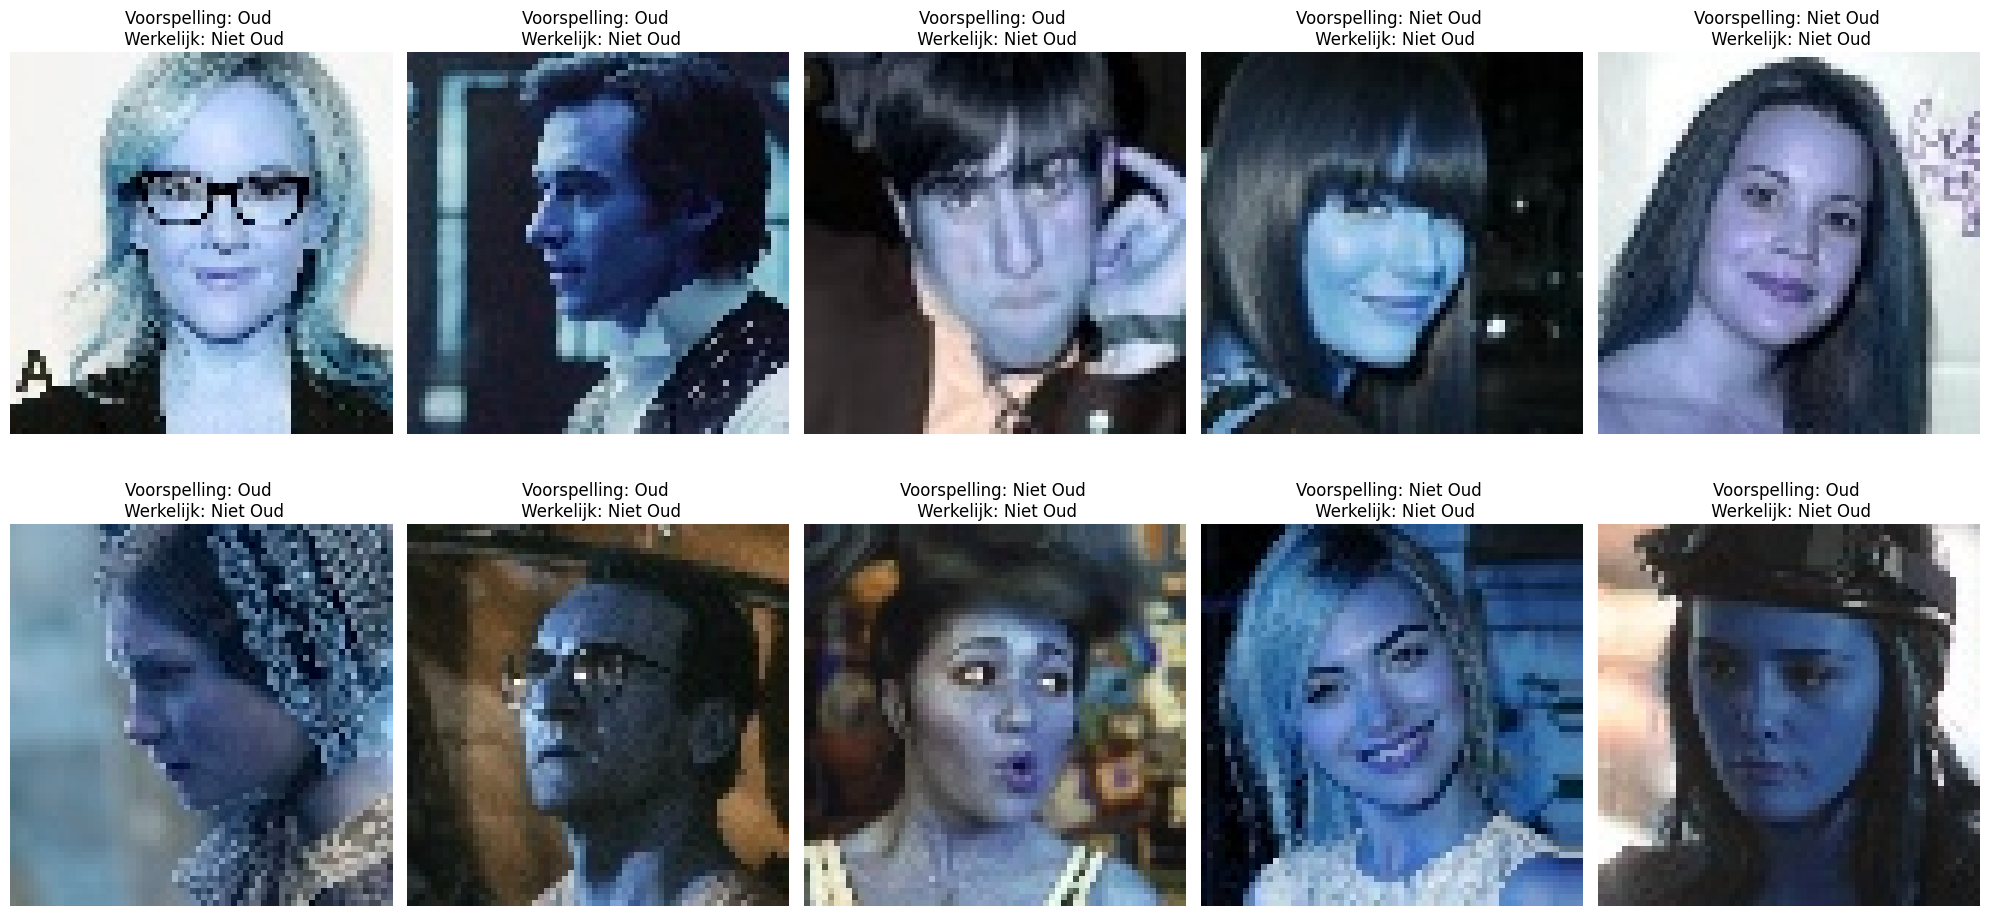

In [117]:
# Voorspellingen maken op de testset
test_predictions = model1.predict(test_images)
test_predictions = np.round(test_predictions)  # Rond de voorspellingen af naar 0 of 1

# Labels aanmaken voor visualisatie (0 = Niet Oud, 1 = Oud)
label_dict = {0: 'Niet Oud', 1: 'Oud'}

# Aantal afbeeldingen om te tonen
num_images_to_show = 10

# Plot een aantal testafbeeldingen samen met hun voorspellingen en werkelijke labels
plt.figure(figsize=(20, 10))
for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1)  # 2 rijen, 5 kolommen
    plt.imshow(test_images[i])
    plt.title(f"Voorspelling: {label_dict[int(test_predictions[i][0])]} \n Werkelijk: {label_dict[int(test_labels[i])]}",
              fontsize=12)
    plt.axis('off')  # Verberg assen

plt.tight_layout()
plt.show()

---

## Model 2: Gecombineerd Convolutioneel Neuraal Netwerk

Model 2 is een meer geavanceerd CNN dat is ontworpen voor geslachtsclassificatie. Dit model bouwt voort op de sterke punten van het vorige model en voegt extra lagen toe om de prestaties te verbeteren.

Belangrijkste Kenmerken:
- Diepere Architectuur: Drie convolutionele lagen met toenemende filtergroottes, wat de mogelijkheid vergroot om complexe patronen in de gegevens te leren.
- Hogere Dropout: Het gebruik van een hogere dropout (0.25 en 0.6) helpt bij het bestrijden van overfitting.
- Batch Normalization: Toegevoegd na elke convolutionele laag om de prestaties te verbeteren.
- Outputlaag: De outputlaag is geconfigureerd voor binaire classificatie met een sigmoid-activatiefunctie.

Bron: Advances in Communication Technology, Computing and Engineering

Editors: Mariyam Ouaissa, Mariya Ouaissa, Sarah El Himer, Zakaria Boulouard
pp. 1 – 10, Copyright © 2021 RGN Publications

In [124]:
# Definieer het gecombineerde model
model2 = models.Sequential([
    # Eerste convolutionele laag
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout om overfitting te voorkomen

    # Tweede convolutionele laag
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout

    # Derde convolutionele laag
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout

    # Flatten laag voor de Fully Connected layers
    layers.Flatten(),

    # Volledig verbonden laag (FC) met dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.6),  # Hoog dropout percentage voor sterke regularisatie

    # Outputlaag voor geslachtsclassificatie
    layers.Dense(1, activation='sigmoid')  # Sigmoid voor binaire classificatie
])

model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236,993 (4.72 MB)

 Trainable params: 1,236,993 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model compileren
model2.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary classificatie voor geslacht
              metrics=['accuracy'])

In [ ]:
# Model trainen
history2 = model2.fit(train_images, train_labels,
                    epochs=25,
                    batch_size=32,
                    validation_data=(test_images, test_labels))

In [ ]:
# Evaluatie van het model
test_loss, test_acc = model2.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
# Plot accuracy per epoch
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Maak voorspellingen op de testset
predictions = (model2.predict(test_images) > 0.5).astype("int32")

# Genereer de confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

# Plot de confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Not Old", "Old"], yticklabels=["Not Old", "Old"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Voorspellingen maken op de testset
test_predictions = model2.predict(test_images)
test_predictions = np.round(test_predictions)  # Rond de voorspellingen af naar 0 of 1

# Labels aanmaken voor visualisatie (0 = Niet Oud, 1 = Oud)
label_dict = {0: 'Niet Oud', 1: 'Oud'}

# Aantal afbeeldingen om te tonen
num_images_to_show = 10

# Plot een aantal testafbeeldingen samen met hun voorspellingen en werkelijke labels
plt.figure(figsize=(20, 10))
for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1)  # 2 rijen, 5 kolommen
    plt.imshow(test_images[i])
    plt.title(f"Voorspelling: {label_dict[int(test_predictions[i][0])]} \n Werkelijk: {label_dict[int(test_labels[i])]}",
              fontsize=12)
    plt.axis('off')  # Verberg assen

plt.tight_layout()
plt.show()

---

## Model 3: Geavanceerd Convolutioneel Neuraal Netwerk
Model 3 is een geavanceerd CNN-model dat speciaal is ontworpen voor zowel leeftijds- als geslachtsclassificatie. Dit model bevat een uitgebreide architectuur met meerdere lagen voor diepere feature-extractie.

Belangrijkste Kenmerken:
- Complexe Architectuur: Vier convolutionele lagen met verschillende filtergroottes en een hoge mate van complexiteit voor het extraheren van diepere kenmerken.
- Batch Normalization: Vermindert interne covariantie en versnelt het leren.
- Dropout: Het model gebruikt dropout van 25% tot 50% voor het verminderen van overfitting, vooral in de volledig verbonden lagen.
- Outputlaag: De laatste laag maakt gebruik van softmax-activatie voor multiclassclassificatie, geschikt voor het classificeren van acht leeftijdsgroepen.

Bron: Face-Based Age and Gender Classification Using Deep Learning Model
Olatunbosun Agbo-Ajala en Serestina Viriri
School of Mathematics, Statistics and Computer Science,
University of KwaZulu-Natal, Westville, Durban 4000, South Africa
ajalabosun@gmail.com, viriris@ukzn.ac.za

In [125]:
# CNN-model opzetten
model3 = models.Sequential([
    layers.Conv2D(96, (7, 7), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(384, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(8, activation='softmax')  # Voor leeftijdsgroepen
])

# Model samenvatten
model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 55, 55, 96)     │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 23, 23, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 9, 9, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 9, 9, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,680 (9.69 MB)

 Trainable params: 2,537,672 (9.68 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [ ]:
# Compileren van het model
model3.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0005),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
# Model trainen
history3 = model3.fit(train_images, train_labels,
                     epochs=25,
                     batch_size=64,
                     validation_split=0.1)

In [ ]:
# Evaluatie van het model
test_loss, test_acc = model3.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
# Plotten van de trainings- en validatienauwkeurigheid
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Voorspellingen maken op de testset
test_predictions = model3.predict(test_images)
test_predictions = np.argmax(test_predictions, axis=1)  # Converteer naar klassen

# Confusion matrix maken
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Visualiseren van de confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[f'Class {i}' for i in range(8)],
             yticklabels=[f'Class {i}' for i in range(8)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Voorspellingen maken op de testset
test_predictions = model3.predict(test_images)
test_predictions = np.round(test_predictions)  # Rond de voorspellingen af naar 0 of 1

# Labels aanmaken voor visualisatie (0 = Niet Oud, 1 = Oud)
label_dict = {0: 'Niet Oud', 1: 'Oud'}

# Aantal afbeeldingen om te tonen
num_images_to_show = 10

# Plot een aantal testafbeeldingen samen met hun voorspellingen en werkelijke labels
plt.figure(figsize=(20, 10))
for i in range(num_images_to_show):
    plt.subplot(2, 5, i + 1)  # 2 rijen, 5 kolommen
    plt.imshow(test_images[i])
    plt.title(f"Voorspelling: {label_dict[int(test_predictions[i][0])]} \n Werkelijk: {label_dict[int(test_labels[i])]}",
              fontsize=12)
    plt.axis('off')  # Verberg assen

plt.tight_layout()
plt.show()

In [115]:
# plot de accuracy en validated accuracy, toon de confusion matrix,
# en toon de een aantal afbeeldingen inclusief of ze volgens het model wel of niet oud zijn,
# doe dit laatste ook voor een paar eigen afbeeldingen


Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?
(type je antwoord en uitleg hieronder)

# Reference

- Rothe, R., Timofte, R., & Van Gool, L. (2018). *Deep expectation of real and apparent age from a single image without facial landmarks*. International Journal of Computer Vision, 126(2-4), 144–157. Springer.

- Rothe, R., Timofte, R., & Van Gool, L. (2015). *DEX: Deep EXpectation of apparent age from a single image*. In IEEE International Conference on Computer Vision Workshops (ICCVW), December.
